In [ ]:

!pip install fastai
!pip install timm

In [1]:
from fastai.vision.all import *

/home/dnth/anaconda3/envs/timm-edge/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
trn_path = Path('./data/paddy-disease-classification/train_images')


In [3]:
dls = ImageDataLoaders.from_folder(trn_path, seed=42, valid_pct=0.2, 
                                item_tfms=[Resize((480, 360))], batch_tfms=aug_transforms(size=(256,192), min_scale=0.75))


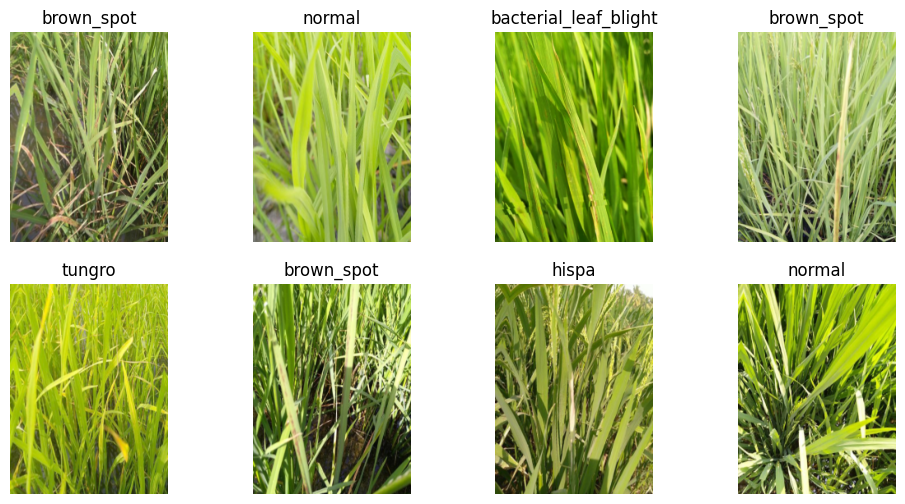

In [4]:
dls.train.show_batch(max_n=8, nrows=2)

In [5]:
import timm
timm.list_models('*conv*t*')

['convit_base',
 'convit_small',
 'convit_tiny',
 'convnext_atto',
 'convnext_atto_ols',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_small_384_in22ft1k',
 'convnext_small_in22ft1k',
 'convnext_small_in22k',
 'convnext_tiny',
 'convnext_tiny_384_in22ft1k',
 'convnext_tiny_hnf',
 'convnext_tiny_in22ft1k',
 'convnext_tiny_in22k',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_xlarge_in22k']

In [6]:
learn = vision_learner(dls, 'convnext_tiny_in22k', metrics=accuracy).to_fp16()

SuggestedLRs(valley=0.0008317637839354575)

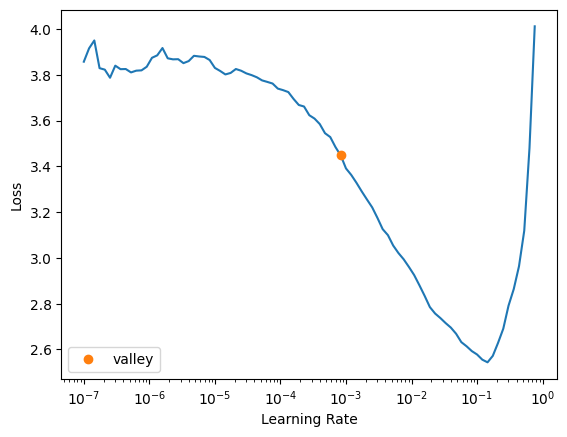

In [7]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,1.490875,0.728548,0.771744,00:41


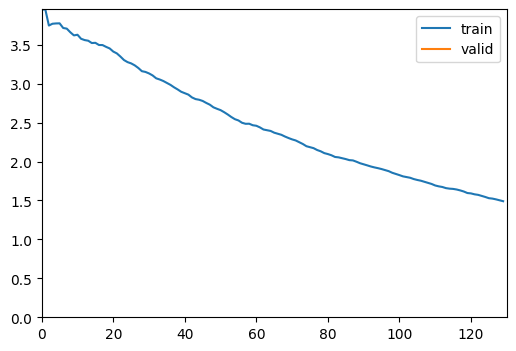

epoch,train_loss,valid_loss,accuracy,time
0,0.908109,0.549016,0.812110,00:43
1,0.757895,0.463395,0.845747,00:42
2,0.644298,0.390732,0.866891,00:42
3,0.538106,0.325083,0.897645,00:42
4,0.453143,0.271382,0.921672,00:44
5,0.379382,0.242415,0.924555,00:44
6,0.324236,0.200884,0.941374,00:43
7,0.279878,0.183065,0.949543,00:43
8,0.234254,0.164384,0.955790,00:43
9,0.205906,0.162097,0.952427,00:42


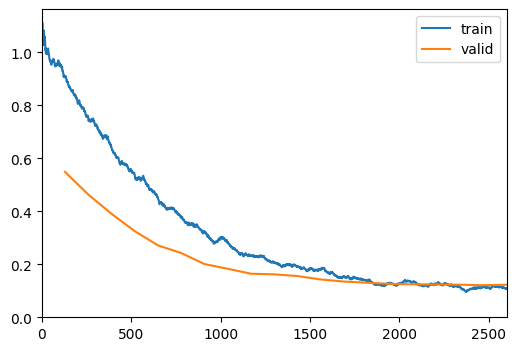

In [8]:
learn.fine_tune(20, base_lr=1e-3, cbs=[ShowGraphCallback()])

In [16]:
learn.export("../../export.pkl")

In [17]:
import torch
from torch.utils.mobile_optimizer import optimize_for_mobile

learn.model.cpu()
learn.model.eval();
example = torch.rand(1, 3, 224, 224)
traced_script_module = torch.jit.trace(learn.model, example)
optimized_traced_model = optimize_for_mobile(traced_script_module)
optimized_traced_model._save_for_lite_interpreter("model.pt")